# Computer vision - Lab  2

Maria Musiał 156062

## Agenda



*   Introduction to image processing,
*   Image representations in diffrent color spaces
*   Point operations Image -> Image,
*   Image arithmetic,
*   Geometric transformations



## Helpers

To perform the tasks, it is necessary to import the libraries used in the script and download the data on which we will be working.

In this script we will be using:
*  Image Lenna (available at the [link](http://www.lenna.org/)) - one of the most popular images historically used for testing image processing and compression,

* "Bug Challenge" - aset of pictures of ant differing in focus set to different parts of the ant(available at the [link](http://grail.cs.washington.edu/projects/photomontage/))

In [1]:
# importing of libraires that will be use in this script
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL


In [2]:
# download and unpack images
# !wget -O lena_std.tif http://www.lenna.org/lena_std.tif
# !wget -O bug.zip http://grail.cs.washington.edu/projects/photomontage/data/bug.zip && unzip -o bug.zip

The colab platform requires a special way to display images with opencv. If the notebook is run in collab, execute the following code:

In [3]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:
    def imshow(img):
        # plt.imshow(img)
        # cv2.namedWindow('ImageWindow', cv2.WINDOW_NORMAL)
        cv2.imshow('ImageWindow', img)
        while True:
        # Wait for a key press to close window and go further
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        cv2.destroyAllWindows()

A function that compares 2 images, checking if the values ​​are the same with minor calculation errors and if the element types are uint8.

In [4]:
def all_close(image_1: np.array, image_2: np.array):
    return (
        np.allclose(image_1, image_2, 0, 2)
        and image_1.dtype == np.uint8
        and image_2.dtype == np.uint8
    )

# Color spaces

Digital image storage is the representation of color in a certain field that to some extent reflects how humans perceives light. The most intuitive is spatial domain, in which the image consists of pixels arranged in the form of a 2D matrix. Each pixel has its own intensity value. This value can be represented in many ways, for example:


* RGB - 3 values that define the degree of saturation with colors: Red, Green, Blue,
* CMYK - similarly, Cyan, Magenta, Yellow, Black (Key color),
* HSV - Hue, Saturation , Value (or Brightness),
* Grayscale,
* RGBA - RGB with an additional Alpha channel that reflects the transparency of the image.
* YCbCr - Luminance (Y), Blue-Difference (Cb), Red-Difference (Cr); separates luminance from chrominance, often used in video and image compression (e.g., JPEG, MPEG).
* XYZ – A device-independent color space based on human visual perception, with values X (Red-Green), Y (Luminance), and Z (Blue-Yellow); used as a reference for other color models and to represent all visible colors.
* Lab – A perceptually uniform color space consisting of Lightness (L), and two color-opponent dimensions: a* (Green to Red) and b* (Blue to Yellow); widely used in color correction, printing, and where color consistency across devices is important.

Different color spaces provide different image processing options. For example, from the HSV space we can determine the brightness directly, while using Grayscale it may be easier to detect the contours of objects in the scene.



Besides the spatial domain, the image can also be processed in the **frequency** domain. A 2D matrix image can be treated as a 2-dimensional signal, so it is subject to all operations on signals such as **Fourier transform**. By representing an image in the frequency domain, we have the possibility of easier detection of edges, blurred areas and image filtering.

RGB color space:

![rgb.png](https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/RGB_color_model.svg/256px-RGB_color_model.svg.png)


CYMK color space:


![cmyk.png](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/CYMK_color_model.svg/256px-CYMK_color_model.svg.png)

## Image loading

The most popular libraries in **Python** for image processing are:
* OpenCV
* Pillow

We can see some differences in image processing by these libraries. **OpenCV** works by default on images in the **BGR** format, while Pillow in the **RGB** format. **BGR** is nothing but the inverted color order for each pixel (Blue, Green, Red).

Shape: (256, 256, 3)
BGR: [125 137 226]
Image load and displayed by OpenCV



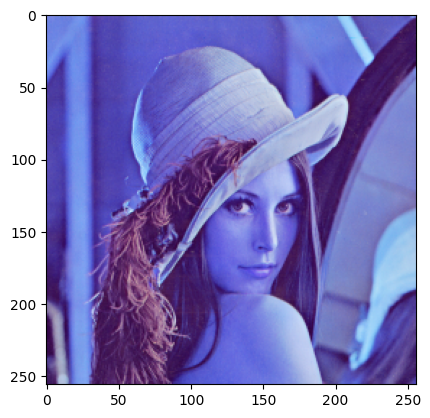

In [5]:
# loading the image using the opencv library
img = cv2.imread(
    "./lena_std.tif", 1
)  # flag: 1 - color (BGR), 0 - grayscale, -1 unchanged it is used to load alpha channel
img = cv2.resize(img, (256, 256))  # change a size to 256x256

print("Shape:", img.shape)
print("BGR:", img[0, 0])
print("Image load and displayed by OpenCV\n")
imshow(img)   #THIS WILL DISPLAY CORRECT COLORS, AS OPENCV COMPENSATES FOR BGR
plt.imshow(img)  #THIS WILL DISPLAY IN RGB, BUT IMAGE IS CODED IN BGR BY OPENCV

In [6]:
# By default opencv process images in BGR order of color
# keep this in mind when using other libraries like pillow
# (both libraries read data into the numpy table, so it is possible to exchange functionality between libraries)
img_pil = np.array(PIL.Image.open("./lena_std.tif"))
img_pil = cv2.resize(img_pil, (256, 256))

print("Shape:", img_pil.shape)
print("RGB:", img_pil[0, 0])
print("Image load by Pillow and displayed by OpenCV\n")
imshow(img_pil)  #blue by opencv

Shape: (256, 256, 3)
RGB: [226 137 125]
Image load by Pillow and displayed by OpenCV



In [7]:
# We can transform the image from RGB to BGR, then it will display properly
imshow(cv2.cvtColor(img_pil, cv2.COLOR_RGB2BGR))  #red by opencv
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))   #blue by opencv


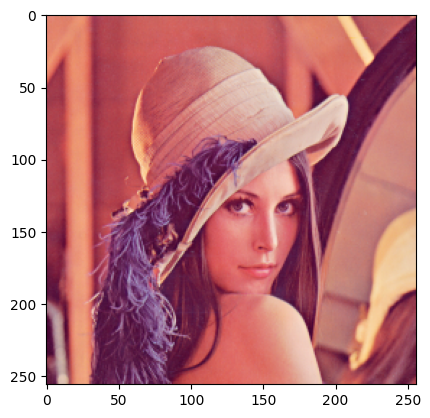

In [8]:
# It is also possible to display an image using the matplotlib library (in RGB color order)
plt.imshow(img_pil)

## Conversion between color spaces

We can move freely between color spaces during image processing. Moreover, most libraries have mechanisms of conversions between the most popular spaces implemented by default.

### RGB - HSV

Assuming input data R, G, B, where $ R, G, B  \in [0,1] $ (if they are in the range $[0,255]$ then they should be divided by $255.0$). The conversion  from RGB to HSV space can be represented as:

$C_{max} = max(R,G,B)$  
$C_{min} = min(R,G,B)$  
$\Delta = C_{max} - C_{min}$  

<br/>

${
H=\left\{
  \begin{array}{ll}
    0{\hspace{0.5cm}\text{for}\hspace{0.5cm}} \Delta = 0\\
    60 * (\frac{G - B}{\Delta} \mod 6){\hspace{0.5cm}\text{for}\hspace{0.5cm}} C_{max} = R\\
    60 * (\frac{B - R}{\Delta} + 2){\hspace{0.5cm}\text{for}\hspace{0.5cm}} C_{max} = G\\
    60 * (\frac{R - G}{\Delta} + 4){\hspace{0.5cm}\text{for}\hspace{0.5cm}} C_{max} = B
  \end{array}
\right.}$  
<br/>
${
S=\left\{
  \begin{array}{ll}
    0{\hspace{0.5cm}\text{for}\hspace{0.5cm}} C_{max} = 0\\
    \frac{\Delta}{C_{max}} {\hspace{0.5cm}\text{for}\hspace{0.5cm}} C_{max} \neq 0
  \end{array}
\right.}$  
<br/>
$V = C_{max}$
<br/>
Note: S and V should be scaled to values between $ [0, 255] $. The range of Hue values ​​for this algorithm is $[0, 359]$, however opencv uses the range $[0,179]$ so the resulting H value should be divided by 2.

### RGB - Grayscale

The conversion from RGB to Grayscale space can be represented as:

$$Gray = 0.2989 * R + 0.5870 * G + 0.1140 * B$$

### OpenCV implementation

OpenCV includes a ready function **cvtColor**, which takes the image to be processed as the first parameter, and a constant specifying the type of conversion as the second parameter (constants marked by variables, eg COLOR_RGB2BGR).

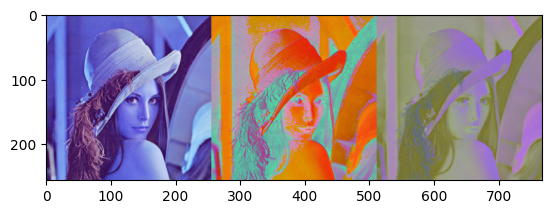

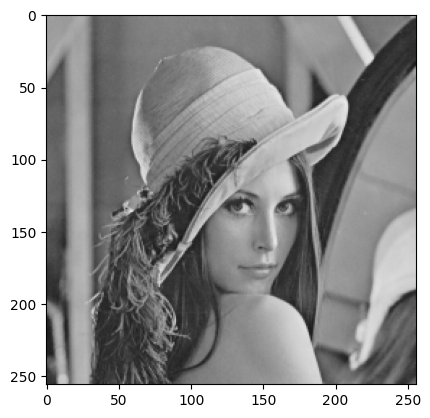

In [9]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(np.concatenate([img_rgb, img_hsv, img_luv], 1), cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_grayscale, cv2.COLOR_BGR2RGB))  #Need to convert to RGB if we show with plotlib
plt.show()


### **Task 1**

Implement the following conversions:
* BGR to RGB,
* BGR to HSV,
* BGR to Grayscale

The results will be compared with the results of the functions included in OpenCV.

**Note:**
There may be slight differences in pixel values between the same transforms, which may be due to numerical errors or simply a different type of rounding / truncating the values when transforming a floating point number to an integer.

**Note 2:** Don't use loops that iterate over each pixel and np.apply_along_axis because it's even slower than loops.

**Note 3:** At the end of the transformation, add type casting to uint8 e.g.img_bgr.astype(np.uint8)

In [28]:
def BGR2RGB(img_bgr):
    return img_bgr[:,:, ::-1]   #3rd dimention is color, so we do x,y,z -> z,y,x (revserse order)


def BGR2HSV(img_bgr):
    img_bgr = img_bgr.astype('float32') / 255.0 #normalize to [0,1]
    
    b, g, r = img_bgr[:, :, 0], img_bgr[:, :, 1], img_bgr[:, :, 2]  #split channels
    Cmax = np.max(img_bgr, axis=2)  #axis=2 ensures that we search for max in colors
    amax = np.argmax(img_bgr, axis=2)  #axis=2 ensures that we search for max in colors
    Cmin = np.min(img_bgr, axis=2)
    
    delta = Cmax-Cmin
    
    hsv = np.zeros(img_bgr.shape, dtype='float32')  
        
    #Hue hsv[x, 0]
    # #delta=0
    hsv[delta == 0, 0] = 0
    # #Cmax=R
    hsv[amax == 2, 0] = (60 * (((g-b)/delta) % 6))[amax == 2]
    # #Cmax = G
    hsv[amax == 1, 0] = (60 * (((b-r)/delta )+2) )[amax == 1]
    # #Cmax = B
    hsv[amax == 0, 0] = (60 * (((r-g)/delta) +4) )[amax == 0]
    
    
    #Saturation
    # #Cmax = 0
    hsv[Cmax == 0, 1] = 0
    # #Cmax != 0
    hsv[Cmax != 0, 1] = delta[Cmax != 0] / Cmax[Cmax != 0]
    
    
    #Value
    hsv[:,:,2] = Cmax
    
    
    #Rescaling for OpenCV
    hsv[:, :, 0] = hsv[:, :, 0]   /2   #changing from [0,1] to [0,179], as opencv uses half of circle(normally it should be value [0,360])
    hsv[:, :, 1] = hsv[:, :, 1] * 255  #[0-255]
    hsv[:, :, 2] = hsv[:, :, 2] * 255   #[0-255]
    hsv = hsv.astype('uint8')
    
    return hsv


def BGR2Gray(img_bgr):
    gray = 0.1140*img_bgr[:,:,0] + 0.5870*img_bgr[:,:,1] +  0.2989*img_bgr[:,:,2]
    return gray.astype(np.uint8)


# img = cv2.imread("./lena_std.tif", 1)
# img = cv2.resize(img, (256, 256))
# # imshow(img)
# img_rgb_2 = BGR2RGB(img)
# # imshow(img_rgb_2)
# img_hsv_2 = BGR2HSV(img)
# # imshow(cv2.cvtColor(img_hsv_2, cv2.COLOR_HSV2BGR))
# # imshow(img_hsv_2)
# plt.imshow(cv2.cvtColor(np.concatenate([img_hsv_2, img_hsv], 1), cv2.COLOR_BGR2RGB))
# img_grayscale_2 = BGR2Gray(img)

# # imshow(np.concatenate([img_rgb_2, img_hsv_2], 1))
# # imshow(img_grayscale_2)

img = cv2.imread("./lena_std.tif", 1)
img = cv2.resize(img, (256, 256))

img_rgb_2 = BGR2RGB(img)
img_hsv_2 = BGR2HSV(img)
img_grayscale_2 = BGR2Gray(img)

imshow(np.concatenate([img_rgb_2, img_hsv_2], 1))
imshow(img_grayscale_2)

print("\n===\n")
print("BGR2RGB Check:", (img_rgb == img_rgb_2).all())
print("BGR2HSV Check:", all_close(img_hsv, img_hsv_2))
print("BGR2Grayscale Check:", all_close(img_grayscale, img_grayscale_2))
print("HSV range Check: ", img_hsv_2.min(0).min(0), img_hsv_2.max(0).max(0))
print("HSV range Check: ", img_hsv.min(0).min(0), img_hsv.max(0).max(0))


===

BGR2RGB Check: True
BGR2HSV Check: False
BGR2Grayscale Check: True
HSV range Check:  [ 0 18 61] [179 241 255]
HSV range Check:  [ 0 19 61] [179 242 255]


## Custom color spaces

Color spaces such as RGB and HSV are standard spaces that result from the nature of light. However, this does not limit you from creating your own color spaces. The **pseudo-coloring** methods are presented below - that is, giving the pixels a color based on an artificially prepared color space.

The **Hot** space may seem to be a particularly interesting space, as it gives a warmer color (yellow) for pixels of greater intensity (grayscale).



In [29]:
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_hot = cv2.applyColorMap(img_grayscale, cv2.COLORMAP_HOT)
img_bone = cv2.applyColorMap(img_grayscale, cv2.COLORMAP_BONE)
img_ocean = cv2.applyColorMap(img_grayscale, cv2.COLORMAP_OCEAN)

imshow(np.concatenate([img, img_hot, img_bone, img_ocean], 1))


To apply our own color space, we can use the functions in the OpenCV **LUT** (Lookup Table). In the example below, 3 color spaces are prepared (lut_1, lut_2, lut_3). Each of these tables is a mapping function between each of the 256 values (uint8) and the new value. This function can also be applied to **multi-channel** images.

* **Lut_1** is an identity function, the same intensity is returned for each pixel intensity,
* **Lut_2** for the first 100 values (0-99) it returns the intensity of 255, for the next 100 values (100-199) the intensity of 0 and for the range 200-256 the intensity of 255. It is nothing else than a image thresholding,
* **Lut_3** - reduce number of colors and create 4 color buckets with 64 values each (256 / 64 = 4). This is also known as posterization.

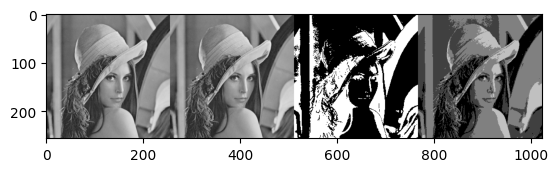

In [12]:
lut_1 = np.array(range(256))
lut_2 = np.array([255] * 100 + [0] * 100 + [255] * 56)
lut_3 = 64 * (np.array(range(256)) // 64)

img_lut_1 = cv2.LUT(img_grayscale, lut_1).astype(np.uint8)
img_lut_2 = cv2.LUT(img_grayscale, lut_2).astype(np.uint8)
img_lut_3 = cv2.LUT(img_grayscale, lut_3).astype(np.uint8)

plt.imshow(cv2.cvtColor((np.concatenate([img_grayscale, img_lut_1, img_lut_2, img_lut_3], 1)), cv2.COLOR_BGR2RGB))
imshow((np.concatenate([img_grayscale, img_lut_1, img_lut_2, img_lut_3], 1)))

### Task 2

For a Lenna image in Grayscale space, first transform it to a space containing 8 colors (buckets), and then convert the image to a **Hot** space.

Display intermediate results.

**Note:** You can use  cv2.applyColorMap.

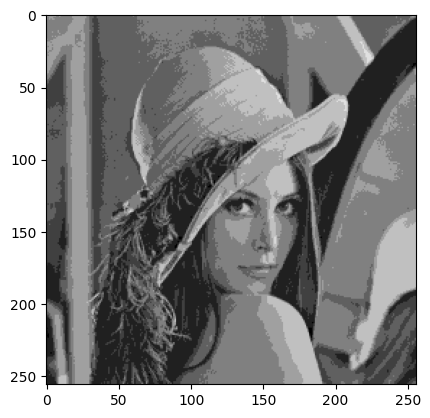

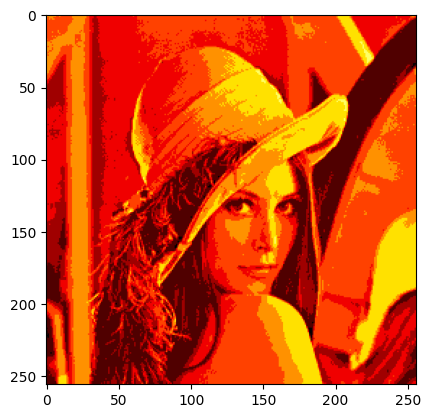

In [13]:
def bucket_8(img_grayscale, n):
    bucketed = np.zeros_like(img_grayscale)
    #to make it usable for different buckets
    bucket_lvl = 256 // n 
    for i in range(n):
        low_bound = i* bucket_lvl
        up_bound = (i+1)* bucket_lvl
        #assign new values based on bounds (each 256/n values is the next boundary)
        bucketed[(img_grayscale>=low_bound) & (img_grayscale<up_bound)] = low_bound
    return bucketed

grey_lena = bucket_8(img_grayscale, 8)
plt.imshow(cv2.cvtColor(grey_lena, cv2.COLOR_BGR2RGB))
plt.show()
hot_lena = cv2.applyColorMap(grey_lena, cv2.COLORMAP_HOT)
plt.imshow(cv2.cvtColor(hot_lena, cv2.COLOR_BGR2RGB))
plt.show()

# Point operations

A point operation is a transformation that transforms an image into another image, for which the result of a particular pixel depends **only** on the corresponding pixel in the input image. Formally, any image operation can be written as follows:

$$F : I_{in} \rightarrow I_{out}$$

where:

* F - transformation function,
* $I_{in}$ - input domain,
* $I_{out}$ - output domain

with a constraint:

$$I_{out}(x,y) = F(I_{in}(x,y))$$

meaning that an output image pixel is the result of the F function on the corresponding input image pixel.

Examples of point operations are (for the  simplicity, we assume that $i \in [0, 1]$):

* identity: $$F(i) = i$$
* inversion: $$F(i) = 1 - i$$
* gamma correction: $$F(i, \gamma) = i^\gamma$$


### Helper functions

In [14]:
def plot_simple(ax):
    ax.set_title("Basic transformations")
    ax.set_xlabel("Input intensity")
    ax.set_ylabel("Output intensity")
    ax.plot(i, identity(i), label="identity")
    ax.plot(i, invert(i), label="inversion")
    ax.grid()
    ax.legend()


def plot_gamma(ax):
    ax.set_title("Gamma correction for diffrent gamma values")
    ax.set_xlabel("Input intensity")
    ax.set_ylabel("Output intensity")
    ax.plot(i, gamma(i, 0.1), label="0.1")
    ax.plot(i, gamma(i, 0.2), label="0.2")
    ax.plot(i, gamma(i, 0.5), label="0.5")
    ax.plot(i, gamma(i, 1.0), label="1.0")
    ax.plot(i, gamma(i, 1.8), label="1.8")
    ax.plot(i, gamma(i, 3.0), label="4.0")
    ax.plot(i, gamma(i, 4.5), label="4.5")
    ax.grid()
    ax.legend()


def plot_l_threshold(ax):
    ax.set_title("Low-pass filtering")
    ax.set_xlabel("Input intensity")
    ax.set_ylabel("Output intensity")
    ax.plot(i, l_threshold(i.copy(), 0.1), label="0.1")
    ax.plot(i, l_threshold(i.copy(), 0.5), label="0.5")
    ax.plot(i, l_threshold(i.copy(), 0.9), label="0.9")
    ax.grid()
    ax.legend()


def plot_h_threshold(ax):
    ax.set_title("High-pass filtering")
    ax.set_xlabel("Input intensity")
    ax.set_ylabel("Output intensity")
    ax.plot(i, h_threshold(i.copy(), 0.1), label="0.1")
    ax.plot(i, h_threshold(i.copy(), 0.5), label="0.5")
    ax.plot(i, h_threshold(i.copy(), 0.9), label="0.9")
    ax.grid()
    ax.legend()


def plot_quad(ax):
    ax.set_title("Quadratic function")
    ax.set_xlabel("Input intensity")
    ax.set_ylabel("Output intensity")
    ax.plot(i, quad(i.copy(), 4.0), label="4.0")
    ax.plot(i, quad(i.copy(), 2.0), label="2.0")
    ax.plot(i, quad(i.copy(), 1.0), label="1.0")
    ax.grid()
    ax.legend()


def plot_stacked(ax):
    ax.set_title("Transformation stacked")
    ax.set_xlabel("Input intensity")
    ax.set_ylabel("Output intensity")
    ax.plot(
        i, h_threshold(gamma(invert(i), 0.3), 0.7), label="threshold(gamma(invert))"
    )
    ax.plot(i, quad(l_threshold(i, 0.4), 3.0), label="quad(threshold)")
    ax.grid()
    ax.legend()

### Point transformations


Below are the implementations of **identity, inversion, and gamma correction** operations and their visualizations.

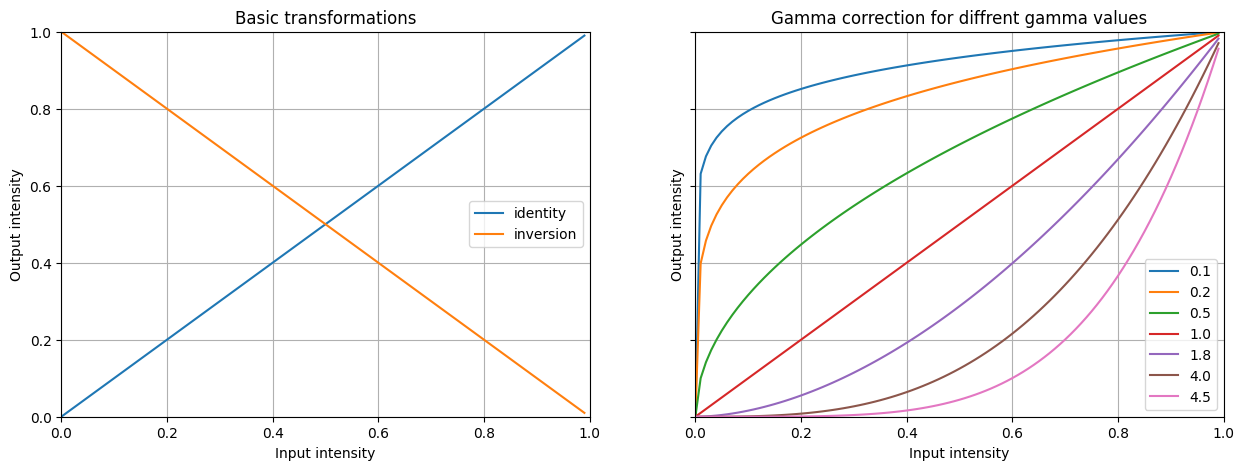

In [15]:
def identity(i):
    return i


def invert(i):
    i_copy = i.copy()
    return 1.0 - i_copy


def gamma(i, g):
    i_copy = i.copy()
    return i_copy**g


i = np.arange(0.0, 1.0, 0.01)  # image domain

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex="all", sharey="all")
axes = plt.gca()
axes.set_xlim([0.0, 1.0])
axes.set_ylim([0.0, 1.0])
plot_simple(ax[0])
plot_gamma(ax[1])
plt.show()

### Task 3

Implement the following transformations:

* Low-pass filter (**l_threshold**) - input intensity values **below** a certain threshold should be reduced to this threshold,
* High-pass filter (**h_threshold**) - input intensity values **above** a certain threshold should be reduced to this threshold,
* Quadratic function (**quad**) - the function should have zeros for the input intensities 0.0 and 1.0 (the **a** parameter should only control the **maximum** of the function)

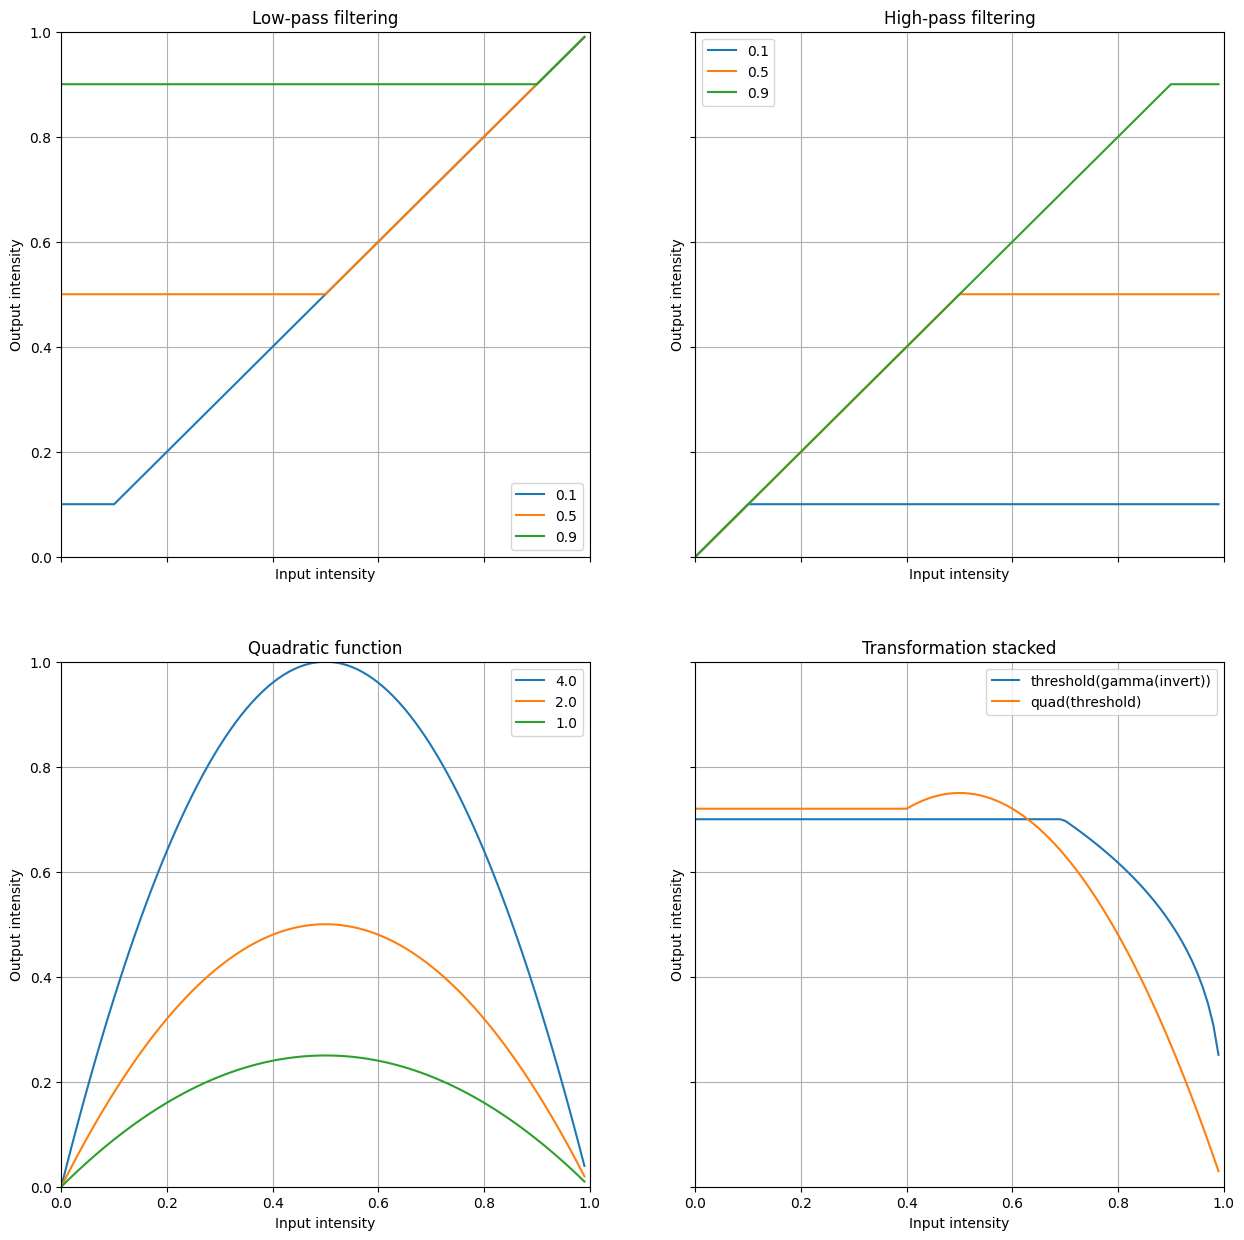

In [16]:
# todo:
def l_threshold(i, threshold):
    i_copy = i.copy()
    i_copy[i_copy < threshold] = threshold
    return i_copy


# todo:
def h_threshold(i, threshold):
    i_copy = i.copy()
    i_copy[i_copy > threshold] = threshold
    return i_copy


# todo:
def quad(i, a):
    #f(x)= -a(x-0)(x-1) ##roots 0 and 1, -a gives height of parabola 
    i_copy = i.copy()
    return -a * i_copy * (i_copy - 1)


fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharex="all", sharey="all")
axes = plt.gca()
axes.set_xlim([0.0, 1.0])
axes.set_ylim([0.0, 1.0])
plot_l_threshold(ax[0, 0])
plot_h_threshold(ax[0, 1])
plot_quad(ax[1, 0])
plot_stacked(ax[1, 1])
plt.show()

### Point operations for images

Above, we have defined the basic image transformation functions.
These operations can be directly applied to images, resulting in a new transformed image.

Below are the same functions as above applied to the image of Lenna.


### Helper functions

In [17]:
def imshow_simple(img_bgr):
    # imshow(img_bgr)
    print("\n===")
    print("Identity | inversion\n")
    img_bgr = img_bgr / 255.0
    image = (np.concatenate([identity(img_bgr), invert(img_bgr)], 1) * 255.0).astype(np.uint8)
    plt.imshow(image)
    plt.show()


def imshow_gamma(img_bgr):
    print("\n===")
    print("Gamma correction 0.1 | 0.5 | 2.0 | 4.0\n")
    img_bgr = img_bgr / 255.0
    plt.imshow(
        (np.concatenate(
            [
                gamma(img_bgr, 0.1),
                gamma(img_bgr, 0.5),
                gamma(img_bgr, 2.0),
                gamma(img_bgr, 4.0),
            ],
            1,
        )
        * 255.0).astype(np.uint8)
    )
    plt.show()


def imshow_l_threshold(img_bgr):
    print("\n===")
    print("Low-pass filter 0.3 | 0.5 | 0.9\n")
    img_bgr = img_bgr / 255.0
    plt.imshow(
        (np.concatenate(
            [
                l_threshold(img_bgr, 0.3),
                l_threshold(img_bgr, 0.5),
                l_threshold(img_bgr, 0.9),
            ],
            1,
        )
        * 255.0).astype(np.uint8)
    )
    plt.show()


def imshow_h_threshold(img_bgr):
    print("\n===")
    print("High-pass filter 0.3 | 0.5 | 0.9\n")
    img_bgr = img_bgr / 255.0
    plt.imshow(
        (np.concatenate(
            [
                h_threshold(img_bgr, 0.3),
                h_threshold(img_bgr, 0.5),
                h_threshold(img_bgr, 0.9),
            ],
            1,
        )
        * 255.0).astype(np.uint8)
    )
    plt.show()
    

def imshow_quad(img_bgr):
    print("\n===")
    print("Quadratic function 4.0 | 2.0 | 1.0\n")
    img_bgr = img_bgr / 255.0
    plt.imshow(
        (np.concatenate([quad(img_bgr, 4.0), quad(img_bgr, 2.0), quad(img_bgr, 1.0)], 1)
        * 255.0).astype(np.uint8)
    )
    plt.show()


def imshow_stacked(img_bgr):
    print("\n===")
    print(
        "Stack of transformation:  h_thrershold(gamma(invert))) | quad(l_threshold())\n"
    )
    img_bgr = img_bgr / 255.0
    plt.imshow(
        (np.concatenate(
            [
                h_threshold(gamma(invert(img_bgr), 0.3), 0.7),
                quad(l_threshold(img_bgr, 0.4), 3.0),
            ],
            1,
        )
        * 255.0).astype(np.uint8)
    )
    plt.show()


===
Identity | inversion



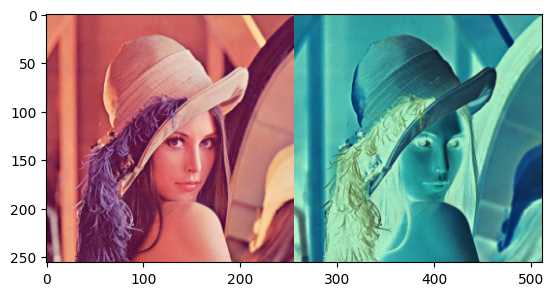


===
Gamma correction 0.1 | 0.5 | 2.0 | 4.0



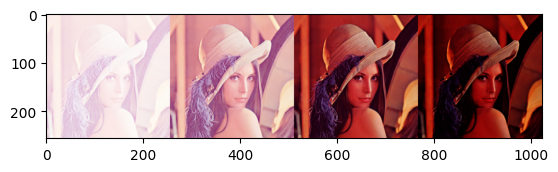


===
Low-pass filter 0.3 | 0.5 | 0.9



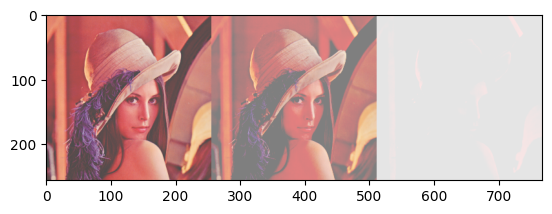


===
High-pass filter 0.3 | 0.5 | 0.9



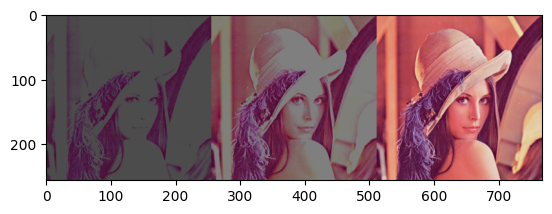


===
Quadratic function 4.0 | 2.0 | 1.0



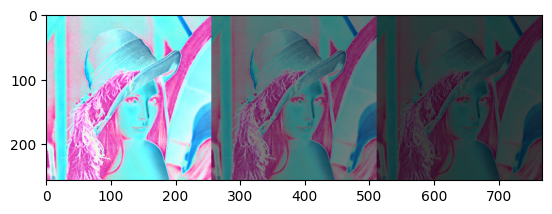


===
Stack of transformation:  h_thrershold(gamma(invert))) | quad(l_threshold())



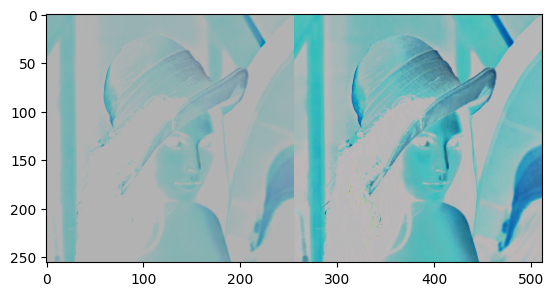

In [18]:
img = cv2.imread("./lena_std.tif", 1)
img = cv2.resize(img, (256, 256))


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imshow_simple(img)
imshow_gamma(img)
imshow_l_threshold(img)
imshow_h_threshold(img)
imshow_quad(img)
imshow_stacked(img)


# Arithmetic operations for images

Image pixel intensity / frequency values are represented as numbers (they are integer or floating point). This implies the ability to perform certain operations on pairs (sets) of images, such as addition, subtraction, averaging, etc.

Below is presented a naive solution to the problem of merging images representing the same object with different sharpness.


In [19]:
files = [
    "./bug/b_bigbug0000_croppped.png",
    "./bug/b_bigbug0001_croppped.png",
    "./bug/b_bigbug0002_croppped.png",
    "./bug/b_bigbug0003_croppped.png",
    "./bug/b_bigbug0004_croppped.png",
    "./bug/b_bigbug0005_croppped.png",
    "./bug/b_bigbug0006_croppped.png",
    "./bug/b_bigbug0007_croppped.png",
    "./bug/b_bigbug0008_croppped.png",
    "./bug/b_bigbug0009_croppped.png",
    "./bug/b_bigbug0010_croppped.png",
    "./bug/b_bigbug0011_croppped.png",
    "./bug/b_bigbug0012_croppped.png",
]

# load images
bugs = [cv2.imread(f, 1) for f in files]
bugs = list(map(lambda i: cv2.resize(i, None, fx=0.3, fy=0.3), bugs))


# loading the expected result of the merging
result = cv2.imread("./bug/result.png", 1)
result = cv2.resize(result, None, fx=0.3, fy=0.3)

We can perform the averaging operation on the loaded images. The expected result is an image with medium sharpness.

If the areas in which the sharpness of the image is high were specified, it would be possible to assemble the sharp image in every place (for this, convolution operations are needed, which will be introduced in the next classes).


===
Photos of ants with sharpness at different distances



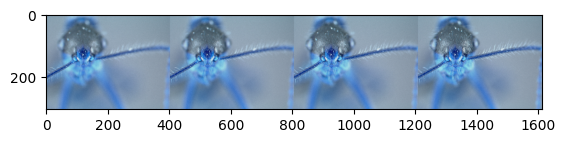

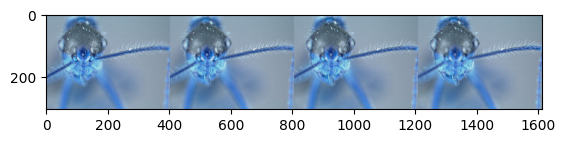

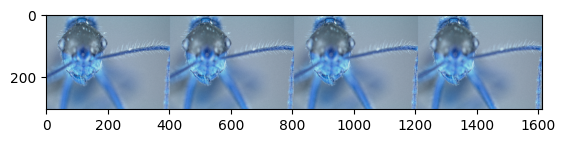


===
Averaging of the component images and the target image



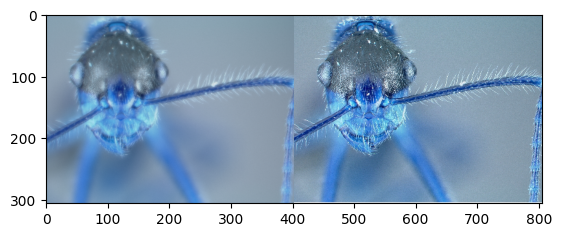

In [20]:
#
bug = np.stack(bugs, 0).mean(0).astype(np.uint8)

print("\n===")
print("Photos of ants with sharpness at different distances\n")
plt.imshow(np.concatenate(bugs[0:4], 1))
plt.show()
plt.imshow(np.concatenate(bugs[4:8], 1))
plt.show()
plt.imshow(np.concatenate(bugs[8:12], 1))
plt.show()
print("\n===")
print("Averaging of the component images and the target image\n")
plt.imshow(np.concatenate([bug, result], 1))
plt.show()

### Task 4

The task is to practice arithmetic operations on images and simple feature detection based on single-point processing.

Using the Lenna image, find areas in the image for which grayscale values are in the range 120-160.

Then propose operations that will return the inverse of the Lenna image (RGB  or BGR for cv2) for selected areas, and copy the pixels from the Lenna image (RGB or BGR for cv2) for the remaining areas.



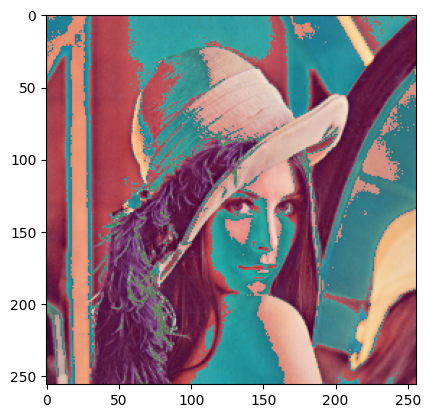

In [30]:
img = cv2.imread("./lena_std.tif", 1)
img = cv2.resize(img, (256, 256))

gray_lena = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()
# img_cop=img.copy()
# img_cop[mask]=255
# plt.imshow(cv2.cvtColor(img_cop, cv2.COLOR_BGR2RGB))
# plt.show()

mask = (gray_lena > 120) & (gray_lena < 160)
img[mask]  = invert(img[mask])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


# Geometric transformations

In addition to operations modifying a single pixel, there are also those that transform the geometry of the entire image. The basic geometric transformations include:

* translation (shifting horizontal and vertical),
* rotation,
* scaling,
* shear

The above operations are called **affine operations** and can be represented as:

$$ y = Tx +b$$
where $x$ is the pixel position vector $(i,j)$ in the input image, $y$ is the pixel position vector $(i',j')$ in the output image, $b$ is the translation vector and is and $T$ is a matrix of transformation

In order for the affine transformation to take only one parameter $T$, it is necessary to extend the number of dimensions to 3, where the pixel vectors on the last dimension have the value 1.

Thus, the general form of an affine transform takes the form:
$$
\begin{bmatrix}
i'\\
j'\\
1
\end{bmatrix}
 =
 \begin{bmatrix}
a_{11} & a_{12} & a_{13}\\
a_{21} & a_{22} & a_{23}\\
0 & 0 & 1
\end{bmatrix}*
\begin{bmatrix}
i\\
j\\
1
\end{bmatrix}
$$

Then, the basic operations can be defined as:
* identity:
$$
T = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix}
$$
* translation (shifting horizontal and vertical),
$$
T = \begin{bmatrix}
1 & 0 & t_x\\
0 & 1 & t_y\\
0 & 0 & 1
\end{bmatrix}
$$
* rotation,
$$
T = \begin{bmatrix}
\cos(\alpha) & -\sin(\alpha) & 0\\
\sin(\alpha) & \cos(\alpha) & 0\\
0 & 0 & 1
\end{bmatrix}
$$
* scaling,
$$
T = \begin{bmatrix}
c_x & 0 & 0\\
0 & c_y & 0\\
0 & 0 & 1
\end{bmatrix}
$$
* shear
$$
T = \begin{bmatrix}
1 & c_x & 0\\
c_y & 1 & 0\\
0 & 0 & 1
\end{bmatrix}
$$

The above operations can be composed by matrix multiplication.

**Note:**  
OpenCV contains an affine operation application operation, however, since the last row always has the same form in basic operations ($[0, 0, 1]$), it takes a transformation in the form:

$$
T = \begin{bmatrix}
a_{11} & a_{12} & a_{13}\\
a_{21} & a_{22} & a_{23}
\end{bmatrix}
$$

The entire matrix is used in more advanced transformations, e.g. in a perspective transformation or homography:
$$
T =  \begin{bmatrix}
a_{11} & a_{12} & a_{13}\\
a_{21} & a_{22} & a_{23}\\
a_{31} & a_{32} & a_{33}
\end{bmatrix}
$$

In [22]:
# translation
t1 = np.array([[1, 0, 50], [0, 1, -50], [0, 0, 1]], np.float32)

# rotation
t2 = np.array([[0.0, -1.0, 256], [1.0, 0.0, 0], [0, 0, 1]], np.float32)

# scaling
t3 = np.array([[0.5, 0, 0], [0, 0.5, 0], [0, 0, 1]], np.float32)


img_t1 = cv2.warpAffine(img, t1[:2], img.shape[:2])
img_t2 = cv2.warpAffine(img_t1, t2[:2], img_t1.shape[:2])
img_t3 = cv2.warpAffine(img_t2, t3[:2], img_t2.shape[:2])

imshow(np.concatenate([img, img_t1, img_t2, img_t3], 1))

The above example shows that the individual results of affine operations can be **lossy**. You can notice that after the first shift operation, part of the color image is out of the frame and is lost. This results in incorrect later processing (despite correct mathematical syntax).

The solution is to combine affine operations using matrix multiplication. Below is a single transform containing all of the above operations, while not losing information between operations.

In [23]:
T = t3 @ t2 @ t1

img_direct = cv2.warpAffine(img, T[:2], img.shape[:2])
imshow(img_direct)


In [24]:
# shear
t4 = np.array([[1, -0.2, 0], [0.1, 1, 0], [0, 0, 1]], np.float32)
img_t4 = cv2.warpAffine(img_direct, t4[:2], img_direct.shape[:2])
imshow(img_t4)

2D Transformations

| Transformation name | included operations | Preserves |
|---|---|---|
|translation| translation| straight lines, parallelism, angles, lengths, orientation    |
|rigid (Euclidean) | translation, rotation| straight lines, parallelism, angles, lengths    |
|similarity | translation, rotation, scaling| straight lines, parallelism, angles    |
|affine | translation, rotation, scaling, affine| straight lines, parallelism    |
|projective  | translation, rotation, scaling, affine, projective| straight lines    |

# Histogram


The calculation of the histogram consists in counting the number of pixels of a given value. In other words, the histogram shows how many pixels of a certain intensity there are in the image.

To calculate a histogram for an image, we can use a ready-made function contained in the matplotlib **hist()** library or numpy **histogram**.

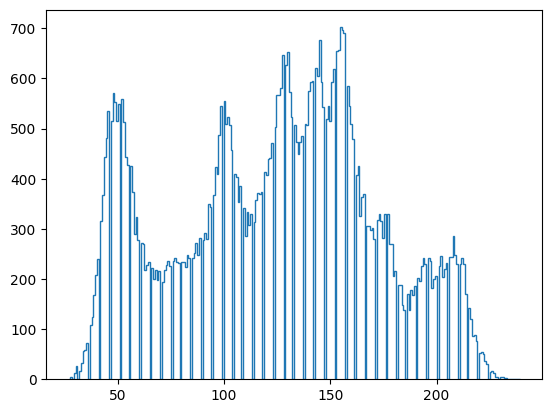

In [25]:
h, _, _ = plt.hist(img_grayscale.flatten(), 256, histtype="step")
plt.show()
imshow(img_grayscale)

Some irregularities in the number of pixel intensity occurrences can be seen from the histogram of the image. When the histogram is **unbalanced**, and therefore certain intensity ranges dominate the image, we can use the histogram equalization method so that the transformed image has a more even number of all intensities.

Thanks to this operation, we can transform very dark images, in which no characteristic points are visible, in such a way that changes in pixel intensity highlight previously invisible changes in the image.

**Histogram equalization** is implemented in the OpenCV library as **equalizeHist** which takes an image as input and returns the image after transformation.

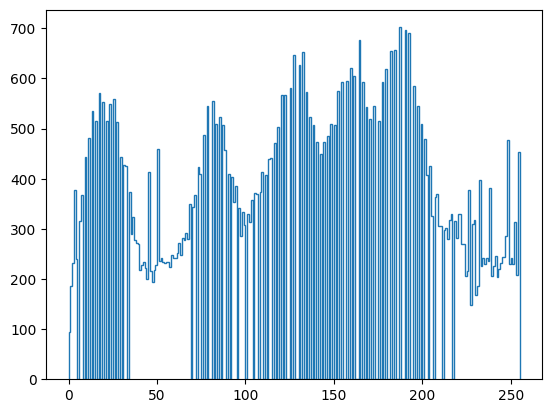

In [26]:
img_equalized = cv2.equalizeHist(img_grayscale)
plt.hist(img_equalized.flatten(), 255, histtype="step")
plt.show()
imshow(img_equalized)

To manually perform a histogram equalization, first calculate  **cumulative distribution function** of the pixel intensity. The cumulative distribution function tells us what the probability is that when selecting any pixel in the image, its intensity will be less than a given intensity on the cumulative distribution function.

The next step is to normalize the obtained cumulative distribution (so that the values of the pledge domain are in the range [0, 255]). In this way, we got our own lookup table, introduced earlier in the class.

Having this table, we can use the **LUT()** operation to get the image after the histogram has been aligned.

[  0   0   0   0   0   0   0   0   0   0   1   1   1   1   2   3   4   4
   5   7   8  10  12  12  14  16  19  21  23  23  25  27  29  30  30  32
  33  35  36  37  37  38  39  40  41  42  42  42  43  44  45  46  46  46
  47  48  49  50  50  51  52  53  54  54  55  55  56  57  58  58  59  60
  61  62  63  63  64  65  67  68  69  69  71  72  74  76  78  78  80  82
  84  86  88  88  89  91  92  94  94  95  96  98  99 100 100 101 103 104
 106 107 107 109 110 112 114 116 116 118 120 122 124 127 127 129 132 134
 136 136 138 140 141 143 145 145 147 149 151 154 156 156 158 161 163 166
 168 168 170 172 174 176 179 179 181 184 187 189 192 192 194 196 198 200
 200 202 203 205 206 208 208 209 210 211 212 213 213 215 216 217 218 219
 219 221 222 223 224 224 224 225 226 227 227 227 228 228 229 230 230 230
 231 232 233 234 235 235 236 236 237 238 239 239 240 241 241 242 243 243
 244 245 246 247 248 248 249 250 251 251 251 252 252 253 253 253 253 254
 254 254 254 254 254 254 254 254 254 254 254 254 25

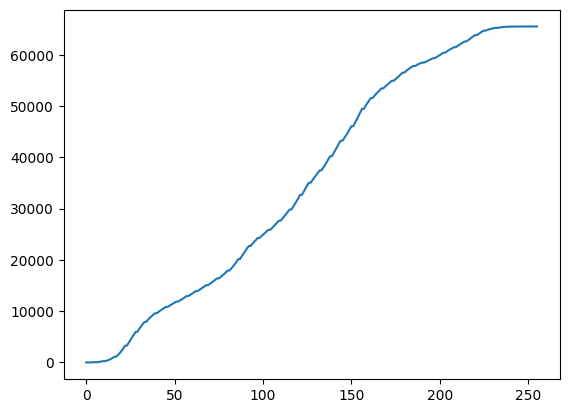

In [27]:
cdf_h = np.cumsum(h)
plt.plot(cdf_h)
cdf_lut = (255 * cdf_h / np.max(cdf_h)).astype(np.uint8)
print(cdf_lut)
imshow(cv2.LUT(img_grayscale, cdf_lut))
